# 最適化手法 (Optimization Methods)

## 概要

創薬研究において、既知の活性化合物から出発して、より良い薬理学的性質を持つ化合物を設計することは重要な課題です。本ノートブックでは、分子最適化に用いられる様々なアルゴリズムについて学習し、実際にPythonとRDKitを用いて分子最適化システムを実装します。

## 学習目標

- 分子最適化の概念と創薬における重要性を理解する
- 遺伝的アルゴリズム（GA）による分子進化の原理を学ぶ
- シミュレーテッドアニーリング（SA）の実装と応用を習得する
- ヒルクライミング法とその変種を理解する
- 目的関数の設計と多目的最適化の概念を学ぶ
- 分子生成アルゴリズムの実装と評価を行う

## 補助資料

**初心者の方へ**: この内容が難しく感じる場合は、以下の補助資料をご参照ください：

- **[最適化手法 初心者ガイド](../optimization-methods-beginner-guide/)**: 基本概念を日常的な例えで解説
- **[最適化手法 用語集](../optimization-methods-glossary/)**: 専門用語の分かりやすい説明と参考リンク

これらの資料は、文系出身の方や化学・情報学の予備知識が少ない方でも理解できるよう工夫されています。

## ダウンロード

<a class="link" href="/files/optimization-methods_executed.ipynb" download>📓 実行済みノートブックをダウンロード</a>

In [1]:
# 必要なライブラリのインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import copy
from rdkit import Chem
from rdkit.Chem import Descriptors, Crippen, Lipinski, rdMolDescriptors, AllChem
from rdkit.Chem import Draw
from rdkit.DataStructs import TanimotoSimilarity
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# 日本語フォントの設定
plt.rcParams['font.family'] = "Noto Sans CJK JP"
sns.set_style("whitegrid")

# ランダムシードの設定
np.random.seed(42)
random.seed(42)

print("ライブラリのインポートが完了しました")

ライブラリのインポートが完了しました


## 1. 分子最適化の基本概念

分子最適化とは、既知の活性化合物から出発して、目標とする性質（活性、選択性、薬物動態等）を改善した新しい化合物を設計する手法です。これは多次元の複雑な最適化問題として定式化できます。

In [2]:
# 分子評価のための目的関数を定義
class MolecularObjective:
    """分子の多目的評価関数"""
    
    def __init__(self, target_props=None):
        """
        target_props: 目標となる分子性質の辞書
        例: {'MW': [300, 500], 'LogP': [1, 3], 'HBD': [0, 3], 'HBA': [0, 7]}
        """
        self.target_props = target_props or {
            'MW': [300, 500],      # 分子量の目標範囲
            'LogP': [1, 3],        # LogPの目標範囲  
            'HBD': [0, 3],         # 水素結合ドナー数
            'HBA': [0, 7],         # 水素結合アクセプター数
            'TPSA': [20, 100],     # 極性表面積
            'RotBonds': [0, 7]     # 回転可能結合数
        }
    
    def calculate_descriptors(self, mol):
        """分子記述子を計算"""
        if mol is None:
            return None
        
        descriptors = {
            'MW': Descriptors.MolWt(mol),
            'LogP': Descriptors.MolLogP(mol),
            'HBD': Descriptors.NumHDonors(mol),
            'HBA': Descriptors.NumHAcceptors(mol),
            'TPSA': Descriptors.TPSA(mol),
            'RotBonds': Descriptors.NumRotatableBonds(mol),
            'RingCount': Descriptors.RingCount(mol),
            'AromaticRings': Descriptors.NumAromaticRings(mol)
        }
        return descriptors
    
    def evaluate_single_property(self, value, target_range):
        """単一性質の評価（0-1スコア）"""
        min_val, max_val = target_range
        if min_val <= value <= max_val:
            # 範囲内の場合は1.0
            return 1.0
        elif value < min_val:
            # 下限以下の場合は距離に応じてペナルティ
            return max(0.0, 1.0 - (min_val - value) / min_val)
        else:
            # 上限以上の場合は距離に応じてペナルティ
            return max(0.0, 1.0 - (value - max_val) / max_val)
    
    def evaluate_molecule(self, smiles):
        """分子の総合評価スコアを計算"""
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return 0.0
        
        descriptors = self.calculate_descriptors(mol)
        if descriptors is None:
            return 0.0
        
        scores = []
        for prop, target_range in self.target_props.items():
            if prop in descriptors:
                score = self.evaluate_single_property(descriptors[prop], target_range)
                scores.append(score)
        
        # 各性質スコアの幾何平均を総合スコアとする
        if scores:
            return np.prod(scores) ** (1.0 / len(scores))
        else:
            return 0.0
    
    def detailed_evaluation(self, smiles):
        """詳細な評価結果を返す"""
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None
        
        descriptors = self.calculate_descriptors(mol)
        if descriptors is None:
            return None
        
        evaluation = {
            'SMILES': smiles,
            'Overall_Score': self.evaluate_molecule(smiles)
        }
        
        for prop, target_range in self.target_props.items():
            if prop in descriptors:
                value = descriptors[prop]
                score = self.evaluate_single_property(value, target_range)
                evaluation[f'{prop}_Value'] = value
                evaluation[f'{prop}_Score'] = score
                evaluation[f'{prop}_Target'] = f"[{target_range[0]}, {target_range[1]}]"
        
        return evaluation

# 目的関数の動作テスト
objective = MolecularObjective()

test_molecules = {
    "アスピリン": "CC(=O)OC1=CC=CC=C1C(=O)O",
    "イブプロフェン": "CC(C)CC1=CC=C(C=C1)C(C)C(=O)O",
    "リピトール": "CC(C)C1=C(C(=C(N1CC(CC(CC(=O)O)O)O)C2=CC=C(C=C2)F)C3=CC=CC=C3)C(=O)NC4=CC=CC=C4",
    "ペニシリン": "CC1(C(N2C(S1)C(C2=O)NC(=O)CC3=CC=CC=C3)C(=O)O)C"
}

print("分子評価システムのテスト:")
print("=" * 60)

for name, smiles in test_molecules.items():
    eval_result = objective.detailed_evaluation(smiles)
    if eval_result:
        print(f"\n{name}:")
        print(f"  SMILES: {smiles}")
        print(f"  総合スコア: {eval_result['Overall_Score']:.3f}")
        print(f"  分子量: {eval_result['MW_Value']:.1f} (スコア: {eval_result['MW_Score']:.3f})")
        print(f"  LogP: {eval_result['LogP_Value']:.2f} (スコア: {eval_result['LogP_Score']:.3f})")

分子評価システムのテスト:

アスピリン:
  SMILES: CC(=O)OC1=CC=CC=C1C(=O)O
  総合スコア: 0.919
  分子量: 180.2 (スコア: 0.601)
  LogP: 1.31 (スコア: 1.000)

イブプロフェン:
  SMILES: CC(C)CC1=CC=C(C=C1)C(C)C(=O)O
  総合スコア: 0.936
  分子量: 206.3 (スコア: 0.688)
  LogP: 3.07 (スコア: 0.976)

リピトール:
  SMILES: CC(C)C1=C(C(=C(N1CC(CC(CC(=O)O)O)O)C2=CC=C(C=C2)F)C3=CC=CC=C3)C(=O)NC4=CC=CC=C4
  総合スコア: 0.425
  分子量: 544.6 (スコア: 0.911)
  LogP: 5.92 (スコア: 0.025)

ペニシリン:
  SMILES: CC1(C(N2C(S1)C(C2=O)NC(=O)CC3=CC=CC=C3)C(=O)O)C
  総合スコア: 0.975
  分子量: 334.4 (スコア: 1.000)
  LogP: 0.86 (スコア: 0.861)


## 2. ヒルクライミング法による分子最適化

ヒルクライミング法は最も基本的な局所探索手法です。現在の解の近傍から より良い解を探索し、改善がなくなるまで繰り返します。

In [3]:
# 分子の構造変換操作
class MolecularMutations:
    """分子構造の変換操作を定義するクラス"""
    
    @staticmethod
    def get_valid_mutations(mol):
        """分子に対して可能な変換操作のリストを取得"""
        mutations = []
        
        # 原子の置換
        for atom in mol.GetAtoms():
            if atom.GetSymbol() == 'C':
                mutations.append(('replace_atom', atom.GetIdx(), 'N'))
                mutations.append(('replace_atom', atom.GetIdx(), 'O'))
            elif atom.GetSymbol() == 'N':
                mutations.append(('replace_atom', atom.GetIdx(), 'C'))
                mutations.append(('replace_atom', atom.GetIdx(), 'O'))
        
        # 結合の追加（環形成）
        for i, atom1 in enumerate(mol.GetAtoms()):
            for j, atom2 in enumerate(mol.GetAtoms()):
                if i < j and mol.GetBondBetweenAtoms(i, j) is None:
                    # 距離が適切で環形成可能な場合
                    if atom1.GetDegree() < 4 and atom2.GetDegree() < 4:
                        mutations.append(('add_bond', i, j))
        
        # 官能基の付加
        for atom in mol.GetAtoms():
            if atom.GetSymbol() == 'C' and atom.GetDegree() < 4:
                mutations.append(('add_methyl', atom.GetIdx()))
                mutations.append(('add_hydroxyl', atom.GetIdx()))
        
        return mutations
    
    @staticmethod
    def apply_mutation(mol, mutation):
        """変換操作を適用して新しい分子を生成"""
        try:
            mol_copy = Chem.RWMol(mol)
            
            if mutation[0] == 'replace_atom':
                atom_idx, new_symbol = mutation[1], mutation[2]
                mol_copy.GetAtomWithIdx(atom_idx).SetAtomicNum(
                    {'C': 6, 'N': 7, 'O': 8}[new_symbol]
                )
            
            elif mutation[0] == 'add_bond':
                atom1_idx, atom2_idx = mutation[1], mutation[2]
                mol_copy.AddBond(atom1_idx, atom2_idx, Chem.BondType.SINGLE)
            
            elif mutation[0] == 'add_methyl':
                atom_idx = mutation[1]
                new_atom_idx = mol_copy.AddAtom(Chem.Atom(6))  # Carbon
                mol_copy.AddBond(atom_idx, new_atom_idx, Chem.BondType.SINGLE)
            
            elif mutation[0] == 'add_hydroxyl':
                atom_idx = mutation[1]
                new_atom_idx = mol_copy.AddAtom(Chem.Atom(8))  # Oxygen
                mol_copy.AddBond(atom_idx, new_atom_idx, Chem.BondType.SINGLE)
            
            # 分子の正規化
            mol_sanitized = mol_copy.GetMol()
            Chem.SanitizeMol(mol_sanitized)
            return mol_sanitized
            
        except:
            return None

# ヒルクライミング法の実装
class HillClimbing:
    """ヒルクライミング法による分子最適化"""
    
    def __init__(self, objective_func, max_iterations=100):
        self.objective_func = objective_func
        self.max_iterations = max_iterations
        self.mutations = MolecularMutations()
    
    def optimize(self, initial_smiles):
        """ヒルクライミング最適化を実行"""
        current_mol = Chem.MolFromSmiles(initial_smiles)
        current_score = self.objective_func.evaluate_molecule(initial_smiles)
        
        history = [{
            'iteration': 0,
            'smiles': initial_smiles,
            'score': current_score,
            'change': 'initial'
        }]
        
        for iteration in range(1, self.max_iterations + 1):
            # 可能な変換操作を取得
            mutations = self.mutations.get_valid_mutations(current_mol)
            
            if not mutations:
                break
            
            best_score = current_score
            best_mol = None
            best_mutation = None
            
            # 全ての変換操作を試す
            for mutation in mutations:
                new_mol = self.mutations.apply_mutation(current_mol, mutation)
                if new_mol is not None:
                    new_smiles = Chem.MolToSmiles(new_mol)
                    new_score = self.objective_func.evaluate_molecule(new_smiles)
                    
                    if new_score > best_score:
                        best_score = new_score
                        best_mol = new_mol
                        best_mutation = mutation
            
            # 改善があった場合は更新
            if best_mol is not None:
                current_mol = best_mol
                current_score = best_score
                current_smiles = Chem.MolToSmiles(current_mol)
                
                history.append({
                    'iteration': iteration,
                    'smiles': current_smiles,
                    'score': current_score,
                    'change': str(best_mutation)
                })
            else:
                # 改善がない場合は終了
                break
        
        return history

# ヒルクライミング法のテスト
initial_molecule = "CCO"  # エタノールから開始
hc = HillClimbing(objective)

print("ヒルクライミング法による分子最適化:")
print("=" * 50)
print(f"初期分子: {initial_molecule}")

hc_history = hc.optimize(initial_molecule)

print(f"\n最適化結果 ({len(hc_history)} ステップ):")
for step in hc_history[-5:]:  # 最後の5ステップを表示
    print(f"  ステップ {step['iteration']:2d}: スコア {step['score']:.3f} - {step['smiles']}")

ヒルクライミング法による分子最適化:
初期分子: CCO


[18:21:36] Explicit valence for atom # 0 O, 3, is greater than permitted
[18:21:36] Explicit valence for atom # 0 N, 4, is greater than permitted
[18:21:36] Explicit valence for atom # 0 O, 4, is greater than permitted
[18:21:36] Explicit valence for atom # 0 N, 4, is greater than permitted
[18:21:36] Explicit valence for atom # 0 O, 4, is greater than permitted
[18:21:36] Explicit valence for atom # 1 O, 3, is greater than permitted
[18:21:36] Explicit valence for atom # 0 N, 4, is greater than permitted
[18:21:36] Explicit valence for atom # 0 O, 4, is greater than permitted
[18:21:36] Explicit valence for atom # 1 N, 4, is greater than permitted
[18:21:36] Explicit valence for atom # 1 O, 4, is greater than permitted
[18:21:36] Explicit valence for atom # 0 N, 4, is greater than permitted
[18:21:36] Explicit valence for atom # 0 O, 4, is greater than permitted
[18:21:36] Explicit valence for atom # 1 N, 4, is greater than permitted
[18:21:36] Explicit valence for atom # 1 O, 4, is g


最適化結果 (20 ステップ):
  ステップ 15: スコア 0.977 - CCC(C(C)(C)C)(C(C)(O)O)C(C)(C)C(C)(C)O
  ステップ 16: スコア 0.978 - COC(C(C)(C)C)(C(C)(O)O)C(C)(C)C(C)(C)O
  ステップ 17: スコア 0.986 - CCC(O)(O)C(OC)(C(C)(C)C)C(C)(C)C(C)(C)O
  ステップ 18: スコア 0.995 - COC(C(C)(C)C)(C(O)(O)C(C)C)C(C)(C)C(C)(C)O
  ステップ 19: スコア 1.000 - COC(C(C)(C)C)(C(C)(C)C(C)(C)O)C(O)(O)C(C)(C)C


[18:21:36] Explicit valence for atom # 0 N, 4, is greater than permitted
[18:21:36] Explicit valence for atom # 0 O, 4, is greater than permitted
[18:21:36] Explicit valence for atom # 1 N, 4, is greater than permitted
[18:21:36] Explicit valence for atom # 1 O, 4, is greater than permitted
[18:21:36] Explicit valence for atom # 3 N, 4, is greater than permitted
[18:21:36] Explicit valence for atom # 3 O, 4, is greater than permitted
[18:21:36] Explicit valence for atom # 4 N, 4, is greater than permitted
[18:21:36] Explicit valence for atom # 4 O, 4, is greater than permitted
[18:21:36] Explicit valence for atom # 5 N, 4, is greater than permitted
[18:21:36] Explicit valence for atom # 5 O, 4, is greater than permitted
[18:21:36] Explicit valence for atom # 7 N, 4, is greater than permitted
[18:21:36] Explicit valence for atom # 7 O, 4, is greater than permitted
[18:21:36] Explicit valence for atom # 6 O, 3, is greater than permitted
[18:21:36] Explicit valence for atom # 6 O, 3, is g

## 3. 遺伝的アルゴリズム（GA）による分子進化

遺伝的アルゴリズムは生物の進化過程を模倣した最適化手法です。複数の候補解（個体）からなる集団を維持し、選択・交叉・突然変異の操作によって解を進化させます。

In [4]:
# 遺伝的アルゴリズムの実装
class GeneticAlgorithm:
    """遺伝的アルゴリズムによる分子最適化"""
    
    def __init__(self, objective_func, population_size=20, generations=50, 
                 mutation_rate=0.3, crossover_rate=0.7):
        self.objective_func = objective_func
        self.population_size = population_size
        self.generations = generations
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.mutations = MolecularMutations()
    
    def initialize_population(self, initial_smiles_list):
        """初期集団を生成"""
        population = []
        for smiles in initial_smiles_list:
            mol = Chem.MolFromSmiles(smiles)
            if mol is not None:
                score = self.objective_func.evaluate_molecule(smiles)
                population.append({
                    'smiles': smiles,
                    'mol': mol,
                    'score': score
                })
        
        # 集団サイズに満たない場合は突然変異で補完
        while len(population) < self.population_size:
            parent = random.choice(population[:len(population)])
            mutated = self.mutate_molecule(parent['mol'])
            if mutated:
                population.append(mutated)
        
        return population[:self.population_size]
    
    def tournament_selection(self, population, tournament_size=3):
        """トーナメント選択"""
        tournament = random.sample(population, min(tournament_size, len(population)))
        return max(tournament, key=lambda x: x['score'])
    
    def crossover_molecules(self, parent1, parent2):
        """分子の交叉操作（単純な断片交換）"""
        try:
            # SMILESの一部を交換する簡単な実装
            smiles1, smiles2 = parent1['smiles'], parent2['smiles']
            
            if len(smiles1) > 4 and len(smiles2) > 4:
                # ランダムな位置で切断して交換
                cut1 = random.randint(2, len(smiles1) - 2)
                cut2 = random.randint(2, len(smiles2) - 2)
                
                new_smiles1 = smiles1[:cut1] + smiles2[cut2:]
                new_smiles2 = smiles2[:cut2] + smiles1[cut1:]
                
                offspring = []
                for smiles in [new_smiles1, new_smiles2]:
                    mol = Chem.MolFromSmiles(smiles)
                    if mol is not None:
                        score = self.objective_func.evaluate_molecule(smiles)
                        offspring.append({
                            'smiles': smiles,
                            'mol': mol,
                            'score': score
                        })
                
                return offspring
        except:
            pass
        
        return [parent1, parent2]
    
    def mutate_molecule(self, mol):
        """分子の突然変異"""
        mutations = self.mutations.get_valid_mutations(mol)
        if mutations:
            mutation = random.choice(mutations)
            new_mol = self.mutations.apply_mutation(mol, mutation)
            if new_mol is not None:
                smiles = Chem.MolToSmiles(new_mol)
                score = self.objective_func.evaluate_molecule(smiles)
                return {
                    'smiles': smiles,
                    'mol': new_mol,
                    'score': score
                }
        return None
    
    def optimize(self, initial_smiles_list):
        """遺伝的アルゴリズム最適化を実行"""
        population = self.initialize_population(initial_smiles_list)
        
        history = {
            'generations': [],
            'best_scores': [],
            'avg_scores': [],
            'best_molecules': []
        }
        
        for generation in range(self.generations):
            # 現世代の統計
            scores = [ind['score'] for ind in population]
            best_ind = max(population, key=lambda x: x['score'])
            
            history['generations'].append(generation)
            history['best_scores'].append(best_ind['score'])
            history['avg_scores'].append(np.mean(scores))
            history['best_molecules'].append(best_ind['smiles'])
            
            # 新世代の生成
            new_population = []
            
            # エリート保存（上位10%）
            elite_size = max(1, self.population_size // 10)
            elite = sorted(population, key=lambda x: x['score'], reverse=True)[:elite_size]
            new_population.extend(elite)
            
            # 交叉と突然変異で残りを生成
            while len(new_population) < self.population_size:
                if random.random() < self.crossover_rate:
                    # 交叉
                    parent1 = self.tournament_selection(population)
                    parent2 = self.tournament_selection(population)
                    offspring = self.crossover_molecules(parent1, parent2)
                    new_population.extend(offspring)
                else:
                    # 突然変異
                    parent = self.tournament_selection(population)
                    mutated = self.mutate_molecule(parent['mol'])
                    if mutated:
                        new_population.append(mutated)
                    else:
                        new_population.append(parent)
            
            population = new_population[:self.population_size]
        
        return history, population

# 初期集団となる分子リスト
initial_molecules = [
    "CCO",           # エタノール
    "CC(=O)O",       # 酢酸
    "CC(C)O",        # イソプロパノール
    "CCCO",          # プロパノール
    "CC(=O)C",       # アセトン
    "CCN",           # エチルアミン
    "C1=CC=CC=C1",   # ベンゼン
    "CC1=CC=CC=C1",  # トルエン
]

# 遺伝的アルゴリズムの実行
ga = GeneticAlgorithm(objective, population_size=15, generations=30)

print("遺伝的アルゴリズムによる分子最適化:")
print("=" * 50)
print(f"初期集団: {len(initial_molecules)} 分子")
print(f"集団サイズ: {ga.population_size}")
print(f"世代数: {ga.generations}")

ga_history, final_population = ga.optimize(initial_molecules)

# 結果の表示
best_final = max(final_population, key=lambda x: x['score'])
print(f"\n最終結果:")
print(f"最高スコア: {best_final['score']:.3f}")
print(f"最良分子: {best_final['smiles']}")

# 上位5分子を表示
top_molecules = sorted(final_population, key=lambda x: x['score'], reverse=True)[:5]
print(f"\n上位5分子:")
for i, mol in enumerate(top_molecules, 1):
    print(f"{i}. スコア {mol['score']:.3f}: {mol['smiles']}")

[18:21:37] Explicit valence for atom # 1 O, 4, is greater than permitted
[18:21:37] Explicit valence for atom # 1 C, 5, is greater than permitted
[18:21:37] Explicit valence for atom # 1 O, 4, is greater than permitted
[18:21:37] Explicit valence for atom # 2 O, 3, is greater than permitted
[18:21:37] SMILES Parse Error: syntax error while parsing: CC()C
[18:21:37] SMILES Parse Error: check for mistakes around position 4:
[18:21:37] CC()C
[18:21:37] ~~~^
[18:21:37] SMILES Parse Error: Failed parsing SMILES 'CC()C' for input: 'CC()C'
[18:21:37] SMILES Parse Error: extra close parentheses while parsing: CC1C)C
[18:21:37] SMILES Parse Error: check for mistakes around position 5:
[18:21:37] CC1C)C
[18:21:37] ~~~~^
[18:21:37] SMILES Parse Error: Failed parsing SMILES 'CC1C)C' for input: 'CC1C)C'
[18:21:37] SMILES Parse Error: extra open parentheses while parsing: CC(=OO1
[18:21:37] SMILES Parse Error: check for mistakes around position 3:
[18:21:37] CC(=OO1
[18:21:37] ~~^
[18:21:37] SMILES 

遺伝的アルゴリズムによる分子最適化:
初期集団: 8 分子
集団サイズ: 15
世代数: 30


[18:21:37] SMILES Parse Error: Failed parsing SMILES 'CC)=O' for input: 'CC)=O'
[18:21:37] SMILES Parse Error: extra close parentheses while parsing: CC(=O))C
[18:21:37] SMILES Parse Error: check for mistakes around position 7:
[18:21:37] CC(=O))C
[18:21:37] ~~~~~~^
[18:21:37] SMILES Parse Error: Failed parsing SMILES 'CC(=O))C' for input: 'CC(=O))C'
[18:21:37] SMILES Parse Error: extra open parentheses while parsing: CCC(COC(C)C
[18:21:37] SMILES Parse Error: check for mistakes around position 4:
[18:21:37] CCC(COC(C)C
[18:21:37] ~~~^
[18:21:37] SMILES Parse Error: Failed parsing SMILES 'CCC(COC(C)C' for input: 'CCC(COC(C)C'
[18:21:37] Explicit valence for atom # 1 C, 5, is greater than permitted
[18:21:37] Explicit valence for atom # 2 O, 4, is greater than permitted
[18:21:37] SMILES Parse Error: extra close parentheses while parsing: CCCC)=O
[18:21:37] SMILES Parse Error: check for mistakes around position 5:
[18:21:37] CCCC)=O
[18:21:37] ~~~~^
[18:21:37] SMILES Parse Error: Failed


最終結果:
最高スコア: 1.000
最良分子: CCCC(=O)C1(C=O)CCC2CCC(C=O)C1C(CC)C2=O

上位5分子:
1. スコア 1.000: CCCC(=O)C1(C=O)CCC2CCC(C=O)C1C(CC)C2=O
2. スコア 1.000: CCCC(=O)C12CCC3C(=O)C4CC(C)C41C(C=O)CC3C2=O
3. スコア 1.000: CCCC(=O)C1(C=O)COC2CCC(C=O)C13CCC3C2=O
4. スコア 1.000: CCCC(=O)C1(C=O)CCC2CCC(C=O)C13CCC3C2=O
5. スコア 1.000: CC1(C=O)C2C3CCCC(=O)C45CCC(C(=O)C(C3)C41)C2C5=O


[18:21:37] SMILES Parse Error: check for mistakes around position 32:
[18:21:37] (C=O)CCC3CCC(C=O)C2C(C3CCC4(C=O)C(=O)CCCC
[18:21:37] ~~~~~~~~~~~~~~~~~~~~^
[18:21:37] SMILES Parse Error: Failed parsing SMILES 'CC1CC(=O)C2(C=O)CCC3CCC(C=O)C2C(C3CCC4(C=O)C(=O)CCCC2CC(C3=O)C41' for input: 'CC1CC(=O)C2(C=O)CCC3CCC(C=O)C2C(C3CCC4(C=O)C(=O)CCCC2CC(C3=O)C41'
[18:21:37] Explicit valence for atom # 17 O, 3, is greater than permitted
[18:21:37] Explicit valence for atom # 15 N, 4, is greater than permitted
[18:21:37] SMILES Parse Error: extra open parentheses while parsing: CCCC(=O)C1(C=O)CCC2CCC(C=O)C1C(CCC3CCC45C(=O)CCCC2CC(C3=O)(C4=O)C15
[18:21:37] SMILES Parse Error: check for mistakes around position 31:
[18:21:37] (C=O)CCC2CCC(C=O)C1C(CCC3CCC45C(=O)CCCC2C
[18:21:37] ~~~~~~~~~~~~~~~~~~~~^
[18:21:37] SMILES Parse Error: Failed parsing SMILES 'CCCC(=O)C1(C=O)CCC2CCC(C=O)C1C(CCC3CCC45C(=O)CCCC2CC(C3=O)(C4=O)C15' for input: 'CCCC(=O)C1(C=O)CCC2CCC(C=O)C1C(CCC3CCC45C(=O)CCCC2CC(C3=O)(C4=O)C15'
[

## 4. シミュレーテッドアニーリング（SA）

シミュレーテッドアニーリングは物理学の焼きなまし過程を模倣した最適化手法です。温度パラメータによって悪化する解の受容確率を制御し、局所最適解からの脱出を可能にします。

In [5]:
# シミュレーテッドアニーリングの実装
class SimulatedAnnealing:
    """シミュレーテッドアニーリングによる分子最適化"""
    
    def __init__(self, objective_func, initial_temp=100.0, final_temp=0.1, 
                 cooling_rate=0.95, max_iterations=1000):
        self.objective_func = objective_func
        self.initial_temp = initial_temp
        self.final_temp = final_temp
        self.cooling_rate = cooling_rate
        self.max_iterations = max_iterations
        self.mutations = MolecularMutations()
    
    def acceptance_probability(self, current_score, new_score, temperature):
        """受容確率を計算"""
        if new_score > current_score:
            return 1.0  # より良い解は必ず受容
        else:
            return np.exp((new_score - current_score) / temperature)
    
    def optimize(self, initial_smiles):
        """シミュレーテッドアニーリング最適化を実行"""
        current_mol = Chem.MolFromSmiles(initial_smiles)
        current_smiles = initial_smiles
        current_score = self.objective_func.evaluate_molecule(current_smiles)
        
        best_mol = current_mol
        best_smiles = current_smiles
        best_score = current_score
        
        temperature = self.initial_temp
        
        history = {
            'iterations': [],
            'temperatures': [],
            'current_scores': [],
            'best_scores': [],
            'accepted': [],
            'molecules': []
        }
        
        iteration = 0
        while temperature > self.final_temp and iteration < self.max_iterations:
            # 近傍解の生成
            mutations = self.mutations.get_valid_mutations(current_mol)
            
            if mutations:
                mutation = random.choice(mutations)
                new_mol = self.mutations.apply_mutation(current_mol, mutation)
                
                if new_mol is not None:
                    new_smiles = Chem.MolToSmiles(new_mol)
                    new_score = self.objective_func.evaluate_molecule(new_smiles)
                    
                    # 受容判定
                    accept_prob = self.acceptance_probability(current_score, new_score, temperature)
                    accept = random.random() < accept_prob
                    
                    if accept:
                        current_mol = new_mol
                        current_smiles = new_smiles
                        current_score = new_score
                        
                        # 最良解の更新
                        if new_score > best_score:
                            best_mol = new_mol
                            best_smiles = new_smiles
                            best_score = new_score
                    
                    # 履歴の記録
                    history['iterations'].append(iteration)
                    history['temperatures'].append(temperature)
                    history['current_scores'].append(current_score)
                    history['best_scores'].append(best_score)
                    history['accepted'].append(accept)
                    history['molecules'].append(current_smiles)
            
            # 温度の降下
            temperature *= self.cooling_rate
            iteration += 1
        
        return history, best_smiles, best_score

# シミュレーテッドアニーリングのテスト
sa = SimulatedAnnealing(objective, initial_temp=50.0, final_temp=0.01, 
                       cooling_rate=0.98, max_iterations=500)

print("シミュレーテッドアニーリングによる分子最適化:")
print("=" * 50)

initial_mol = "c1ccccc1"  # ベンゼンから開始
print(f"初期分子: {initial_mol}")

sa_history, sa_best_smiles, sa_best_score = sa.optimize(initial_mol)

print(f"\n最適化結果:")
print(f"最良分子: {sa_best_smiles}")
print(f"最高スコア: {sa_best_score:.3f}")
print(f"実行ステップ数: {len(sa_history['iterations'])}")

[18:21:38] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 5
[18:21:38] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
[18:21:38] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5
[18:21:38] Can't kekulize mol.  Unkekulized atoms: 0 1 3 4 5
[18:21:38] Explicit valence for atom # 1 O, 4, is greater than permitted
[18:21:38] Can't kekulize mol.  Unkekulized atoms: 0 1 2 4 5
[18:21:38] Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 5
[18:21:38] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
[18:21:38] Can't kekulize mol.  Unkekulized atoms: 0 1 3 4 5
[18:21:38] Can't kekulize mol.  Unkekulized atoms: 0 1 3 4 5
[18:21:38] Can't kekulize mol.  Unkekulized atoms: 0 1 3 4 5
[18:21:38] Explicit valence for atom # 1 O, 4, is greater than permitted
[18:21:38] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
[18:21:38] Can't kekulize mol.  Unkekulized atoms: 1 2 3 4 5
[18:21:38] Can't kekulize mol.  Unkekulized atoms: 0 2 3 4 5
[18:21:38] Explicit valence for atom # 4 O, 4, is greater tha

シミュレーテッドアニーリングによる分子最適化:
初期分子: c1ccccc1

最適化結果:
最良分子: CCc1c2nc-2c2c1N2
最高スコア: 0.856
実行ステップ数: 17


## 5. 最適化手法の比較と可視化

In [6]:
# 各最適化手法の性能を比較
plt.rcParams['font.family'] = "Noto Sans CJK JP"

# 共通の初期分子で比較
comparison_initial = "CCO"

# ヒルクライミング
hc_comp = HillClimbing(objective, max_iterations=50)
hc_result = hc_comp.optimize(comparison_initial)

# シミュレーテッドアニーリング
sa_comp = SimulatedAnnealing(objective, initial_temp=20.0, final_temp=0.1, 
                            cooling_rate=0.95, max_iterations=50)
sa_result, sa_best, sa_score = sa_comp.optimize(comparison_initial)

# 遺伝的アルゴリズム（少世代で比較）
ga_comp = GeneticAlgorithm(objective, population_size=10, generations=20)
ga_result, ga_pop = ga_comp.optimize([comparison_initial] * 5)

# 結果の可視化
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. ヒルクライミングの進化
hc_iterations = [step['iteration'] for step in hc_result]
hc_scores = [step['score'] for step in hc_result]

axes[0, 0].plot(hc_iterations, hc_scores, 'bo-', linewidth=2, markersize=6)
axes[0, 0].set_xlabel('反復回数')
axes[0, 0].set_ylabel('スコア')
axes[0, 0].set_title('ヒルクライミング法')
axes[0, 0].grid(True, alpha=0.3)

# 2. シミュレーテッドアニーリングの進化
if sa_result['iterations']:
    axes[0, 1].plot(sa_result['iterations'], sa_result['current_scores'], 
                   'g-', alpha=0.7, label='現在解')
    axes[0, 1].plot(sa_result['iterations'], sa_result['best_scores'], 
                   'r-', linewidth=2, label='最良解')
    axes[0, 1].set_xlabel('反復回数')
    axes[0, 1].set_ylabel('スコア')
    axes[0, 1].set_title('シミュレーテッドアニーリング')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

# 3. 遺伝的アルゴリズムの進化
axes[1, 0].plot(ga_result['generations'], ga_result['best_scores'], 
               'ro-', linewidth=2, label='最良個体')
axes[1, 0].plot(ga_result['generations'], ga_result['avg_scores'], 
               'bo-', linewidth=1, alpha=0.7, label='平均')
axes[1, 0].set_xlabel('世代数')
axes[1, 0].set_ylabel('スコア')
axes[1, 0].set_title('遺伝的アルゴリズム')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. 温度変化（SA）
if sa_result['iterations']:
    ax_temp = axes[1, 1]
    ax_score = ax_temp.twinx()
    
    line1 = ax_temp.plot(sa_result['iterations'], sa_result['temperatures'], 
                        'b-', linewidth=2, label='温度')
    line2 = ax_score.plot(sa_result['iterations'], sa_result['best_scores'], 
                         'r-', linewidth=2, label='最良スコア')
    
    ax_temp.set_xlabel('反復回数')
    ax_temp.set_ylabel('温度', color='b')
    ax_score.set_ylabel('スコア', color='r')
    ax_temp.set_title('SA: 温度とスコアの変化')
    
    # 凡例をまとめる
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax_temp.legend(lines, labels, loc='upper right')

plt.tight_layout()
plt.show()

# 最終結果の比較表
comparison_results = {
    'ヒルクライミング': {
        'final_score': hc_scores[-1] if hc_scores else 0,
        'iterations': len(hc_result),
        'final_molecule': hc_result[-1]['smiles'] if hc_result else None
    },
    'シミュレーテッドアニーリング': {
        'final_score': sa_score,
        'iterations': len(sa_result['iterations']),
        'final_molecule': sa_best
    },
    '遺伝的アルゴリズム': {
        'final_score': ga_result['best_scores'][-1] if ga_result['best_scores'] else 0,
        'iterations': ga_result['generations'][-1] if ga_result['generations'] else 0,
        'final_molecule': ga_result['best_molecules'][-1] if ga_result['best_molecules'] else None
    }
}

print("\n最適化手法の比較結果:")
print("=" * 60)
for method, result in comparison_results.items():
    print(f"\n{method}:")
    print(f"  最終スコア: {result['final_score']:.3f}")
    print(f"  実行回数/世代: {result['iterations']}")
    print(f"  最終分子: {result['final_molecule']}")

[18:21:38] Explicit valence for atom # 0 O, 3, is greater than permitted
[18:21:38] Explicit valence for atom # 0 N, 4, is greater than permitted
[18:21:38] Explicit valence for atom # 0 O, 4, is greater than permitted
[18:21:38] Explicit valence for atom # 0 N, 4, is greater than permitted
[18:21:38] Explicit valence for atom # 0 O, 4, is greater than permitted
[18:21:38] Explicit valence for atom # 1 O, 3, is greater than permitted
[18:21:38] Explicit valence for atom # 0 N, 4, is greater than permitted
[18:21:38] Explicit valence for atom # 0 O, 4, is greater than permitted
[18:21:38] Explicit valence for atom # 1 N, 4, is greater than permitted
[18:21:38] Explicit valence for atom # 1 O, 4, is greater than permitted
[18:21:38] Explicit valence for atom # 0 N, 4, is greater than permitted
[18:21:38] Explicit valence for atom # 0 O, 4, is greater than permitted
[18:21:38] Explicit valence for atom # 1 N, 4, is greater than permitted
[18:21:38] Explicit valence for atom # 1 O, 4, is g


最適化手法の比較結果:

ヒルクライミング:
  最終スコア: 1.000
  実行回数/世代: 20
  最終分子: COC(C(C)(C)C)(C(C)(C)C(C)(C)O)C(O)(O)C(C)(C)C

シミュレーテッドアニーリング:
  最終スコア: 0.000
  実行回数/世代: 4
  最終分子: CCO

遺伝的アルゴリズム:
  最終スコア: 0.913
  実行回数/世代: 19
  最終分子: CCCC(O)CCCC1CC1COO


## 6. 多目的最適化

実際の創薬では、活性、選択性、薬物動態、毒性など複数の目標を同時に最適化する必要があります。パレート最適化の概念を実装します。

In [7]:
# 多目的最適化のためのパレート最適解の実装
class MultiObjectiveOptimization:
    """多目的最適化クラス"""
    
    def __init__(self):
        self.objectives = {
            'drug_likeness': MolecularObjective(),
            'synthetic_accessibility': self.synthetic_accessibility_score,
            'diversity': self.diversity_score
        }
        self.reference_molecules = []
    
    def synthetic_accessibility_score(self, smiles):
        """合成容易性スコア（簡易版）"""
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return 0.0
        
        # 分子量に基づく簡単な近似
        mw = Descriptors.MolWt(mol)
        ring_count = Descriptors.RingCount(mol)
        
        # 中程度の分子量で環数が少ないほど合成しやすいと仮定
        mw_score = max(0, 1.0 - abs(mw - 350) / 350)
        ring_score = max(0, 1.0 - ring_count / 5.0)
        
        return (mw_score + ring_score) / 2.0
    
    def diversity_score(self, smiles):
        """多様性スコア（他の分子との非類似性）"""
        if not self.reference_molecules:
            return 1.0
        
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return 0.0
        
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2)
        similarities = []
        
        for ref_smiles in self.reference_molecules:
            ref_mol = Chem.MolFromSmiles(ref_smiles)
            if ref_mol is not None:
                ref_fp = AllChem.GetMorganFingerprintAsBitVect(ref_mol, 2)
                sim = TanimotoSimilarity(fp, ref_fp)
                similarities.append(sim)
        
        # 最大類似度の逆数を多様性とする
        if similarities:
            return 1.0 - max(similarities)
        else:
            return 1.0
    
    def evaluate_multi_objective(self, smiles):
        """多目的評価を実行"""
        scores = {}
        for obj_name, obj_func in self.objectives.items():
            if obj_name == 'drug_likeness':
                scores[obj_name] = obj_func.evaluate_molecule(smiles)
            else:
                scores[obj_name] = obj_func(smiles)
        
        return scores
    
    def is_pareto_dominant(self, scores1, scores2):
        """scores1がscores2をパレート支配するかチェック"""
        better_in_at_least_one = False
        
        for obj in scores1:
            if scores1[obj] < scores2[obj]:
                return False
            elif scores1[obj] > scores2[obj]:
                better_in_at_least_one = True
        
        return better_in_at_least_one
    
    def find_pareto_front(self, molecules_scores):
        """パレート最適解集合を求める"""
        pareto_front = []
        
        for i, (mol1, scores1) in enumerate(molecules_scores):
            is_dominated = False
            
            for j, (mol2, scores2) in enumerate(molecules_scores):
                if i != j and self.is_pareto_dominant(scores2, scores1):
                    is_dominated = True
                    break
            
            if not is_dominated:
                pareto_front.append((mol1, scores1))
        
        return pareto_front

# 多目的最適化のテスト
multi_opt = MultiObjectiveOptimization()

# テスト分子群
test_molecules_multi = [
    "CCO",
    "CC(=O)OC1=CC=CC=C1C(=O)O",  # アスピリン
    "CC(C)CC1=CC=C(C=C1)C(C)C(=O)O",  # イブプロフェン
    "CN1C=NC2=C1C(=O)N(C(=O)N2C)C",  # カフェイン
    "c1ccc2c(c1)c(cn2)CCN",  # トリプタミン
    "CC1=CC=C(C=C1)C(C)C(=O)O",  # 簡単なプロフェン誘導体
]

# 各分子の多目的評価
print("多目的最適化の評価:")
print("=" * 60)

molecules_with_scores = []
for smiles in test_molecules_multi:
    scores = multi_opt.evaluate_multi_objective(smiles)
    molecules_with_scores.append((smiles, scores))
    
    print(f"\n分子: {smiles}")
    for obj_name, score in scores.items():
        print(f"  {obj_name}: {score:.3f}")

# パレート最適解の特定
pareto_front = multi_opt.find_pareto_front(molecules_with_scores)

print(f"\nパレート最適解 ({len(pareto_front)} 分子):")
print("=" * 40)
for i, (smiles, scores) in enumerate(pareto_front, 1):
    print(f"{i}. {smiles}")
    for obj_name, score in scores.items():
        print(f"   {obj_name}: {score:.3f}")
    print()

多目的最適化の評価:

分子: CCO
  drug_likeness: 0.000
  synthetic_accessibility: 0.566
  diversity: 1.000

分子: CC(=O)OC1=CC=CC=C1C(=O)O
  drug_likeness: 0.919
  synthetic_accessibility: 0.657
  diversity: 1.000

分子: CC(C)CC1=CC=C(C=C1)C(C)C(=O)O
  drug_likeness: 0.936
  synthetic_accessibility: 0.695
  diversity: 1.000

分子: CN1C=NC2=C1C(=O)N(C(=O)N2C)C
  drug_likeness: 0.000
  synthetic_accessibility: 0.577
  diversity: 1.000

分子: c1ccc2c(c1)c(cn2)CCN
  drug_likeness: 0.000
  synthetic_accessibility: 0.000
  diversity: 1.000

分子: CC1=CC=C(C=C1)C(C)C(=O)O
  drug_likeness: 0.904
  synthetic_accessibility: 0.635
  diversity: 1.000

パレート最適解 (1 分子):
1. CC(C)CC1=CC=C(C=C1)C(C)C(=O)O
   drug_likeness: 0.936
   synthetic_accessibility: 0.695
   diversity: 1.000



[18:21:40] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8
[18:21:40] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4 5 6 7 8


## 7. 最適化結果の詳細分析と可視化

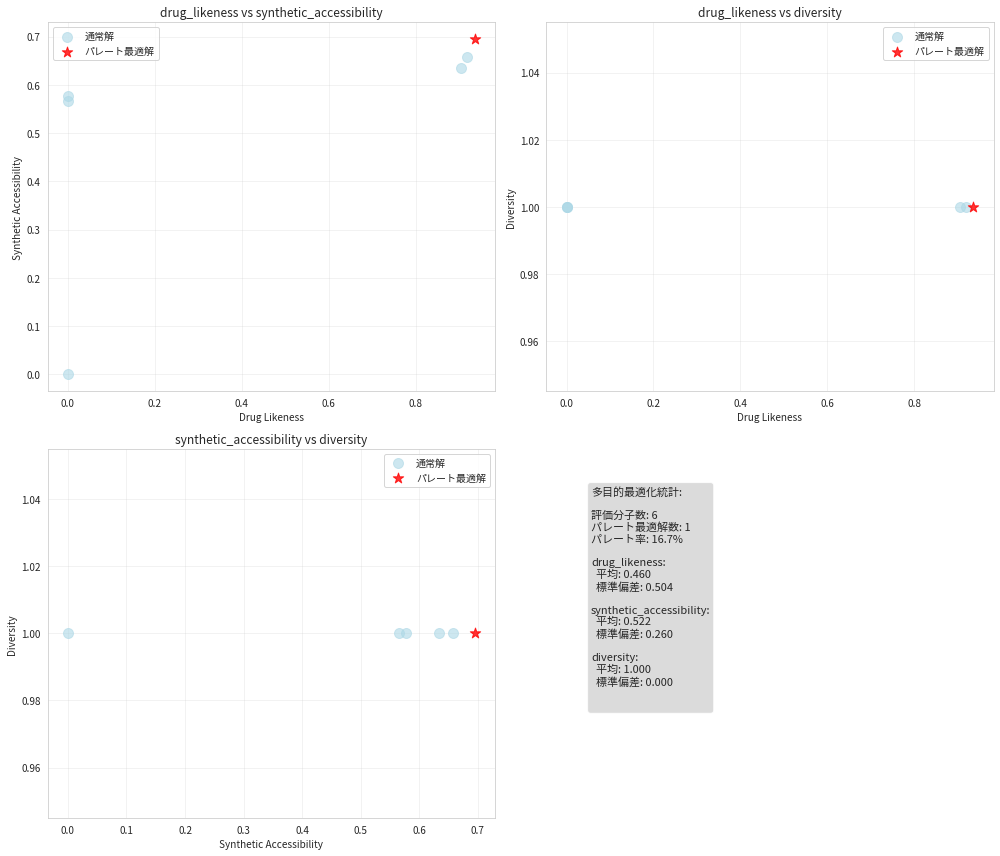

パレート最適解の分子構造:
1個のパレート最適解が見つかりました。
1. CC(C)CC1=CC=C(C=C1)C(C)C(=O)O
   薬らしさ: 0.936
   合成容易性: 0.695
   多様性: 1.000


In [8]:
# 3次元散布図による多目的最適化結果の可視化
plt.rcParams['font.family'] = "Noto Sans CJK JP"

# 評価結果をDataFrameに変換
data_for_plot = []
for smiles, scores in molecules_with_scores:
    row = {'SMILES': smiles}
    row.update(scores)
    row['is_pareto'] = (smiles, scores) in pareto_front
    data_for_plot.append(row)

df_multi = pd.DataFrame(data_for_plot)

# 2次元散布図行列
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

objectives = ['drug_likeness', 'synthetic_accessibility', 'diversity']
combinations = [
    ('drug_likeness', 'synthetic_accessibility'),
    ('drug_likeness', 'diversity'),
    ('synthetic_accessibility', 'diversity')
]

for i, (obj1, obj2) in enumerate(combinations):
    row, col = divmod(i, 2)
    ax = axes[row, col]
    
    # 通常の分子
    normal_mols = df_multi[~df_multi['is_pareto']]
    pareto_mols = df_multi[df_multi['is_pareto']]
    
    ax.scatter(normal_mols[obj1], normal_mols[obj2], 
              c='lightblue', alpha=0.6, s=100, label='通常解')
    ax.scatter(pareto_mols[obj1], pareto_mols[obj2], 
              c='red', alpha=0.8, s=120, label='パレート最適解', marker='*')
    
    ax.set_xlabel(obj1.replace('_', ' ').title())
    ax.set_ylabel(obj2.replace('_', ' ').title())
    ax.set_title(f'{obj1} vs {obj2}')
    ax.legend()
    ax.grid(True, alpha=0.3)

# 4番目のプロットには統計情報を表示
axes[1, 1].axis('off')
stats_text = "多目的最適化統計:\n\n"
stats_text += f"評価分子数: {len(molecules_with_scores)}\n"
stats_text += f"パレート最適解数: {len(pareto_front)}\n"
stats_text += f"パレート率: {len(pareto_front)/len(molecules_with_scores)*100:.1f}%\n\n"

for obj in objectives:
    mean_score = df_multi[obj].mean()
    std_score = df_multi[obj].std()
    stats_text += f"{obj}:\n"
    stats_text += f"  平均: {mean_score:.3f}\n"
    stats_text += f"  標準偏差: {std_score:.3f}\n\n"

axes[1, 1].text(0.1, 0.9, stats_text, transform=axes[1, 1].transAxes, 
                fontsize=11, verticalalignment='top', 
                bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

plt.tight_layout()
plt.show()

# パレート最適解の分子構造表示
print("パレート最適解の分子構造:")
print("=" * 40)

pareto_mols = [Chem.MolFromSmiles(smiles) for smiles, _ in pareto_front]
pareto_legends = [f"Score: DL={scores['drug_likeness']:.2f}, SA={scores['synthetic_accessibility']:.2f}, Div={scores['diversity']:.2f}" 
                  for smiles, scores in pareto_front]

if pareto_mols:
    # 分子構造の表示
    print(f"{len(pareto_mols)}個のパレート最適解が見つかりました。")
    for i, (smiles, scores) in enumerate(pareto_front, 1):
        print(f"{i}. {smiles}")
        print(f"   薬らしさ: {scores['drug_likeness']:.3f}")
        print(f"   合成容易性: {scores['synthetic_accessibility']:.3f}")
        print(f"   多様性: {scores['diversity']:.3f}")

## 8. 最適化アルゴリズムの性能指標

最適化アルゴリズムのベンチマーク実行中...


[18:21:40] Explicit valence for atom # 0 O, 3, is greater than permitted
[18:21:40] Explicit valence for atom # 0 N, 4, is greater than permitted
[18:21:40] Explicit valence for atom # 0 O, 4, is greater than permitted
[18:21:40] Explicit valence for atom # 0 N, 4, is greater than permitted
[18:21:40] Explicit valence for atom # 0 O, 4, is greater than permitted
[18:21:40] Explicit valence for atom # 1 O, 3, is greater than permitted
[18:21:40] Explicit valence for atom # 0 N, 4, is greater than permitted
[18:21:40] Explicit valence for atom # 0 O, 4, is greater than permitted
[18:21:40] Explicit valence for atom # 1 N, 4, is greater than permitted
[18:21:40] Explicit valence for atom # 1 O, 4, is greater than permitted
[18:21:40] Explicit valence for atom # 0 N, 4, is greater than permitted
[18:21:40] Explicit valence for atom # 0 O, 4, is greater than permitted
[18:21:40] Explicit valence for atom # 1 N, 4, is greater than permitted
[18:21:40] Explicit valence for atom # 1 O, 4, is g

最適化アルゴリズムのベンチマーク結果:

Hill Climbing:
  平均最終スコア: 1.000 ± 0.000
  平均改善度: 1.000 ± 0.000
  成功率: 100.0%
  最高スコア: 1.000
  最低スコア: 1.000

Simulated Annealing:
  平均最終スコア: 0.379 ± 0.328
  平均改善度: 0.379 ± 0.328
  成功率: 60.0%
  最高スコア: 0.836
  最低スコア: 0.000

Genetic Algorithm:
  平均最終スコア: 0.986 ± 0.019
  平均改善度: 0.473 ± 0.019
  成功率: 100.0%
  最高スコア: 1.000
  最低スコア: 0.948


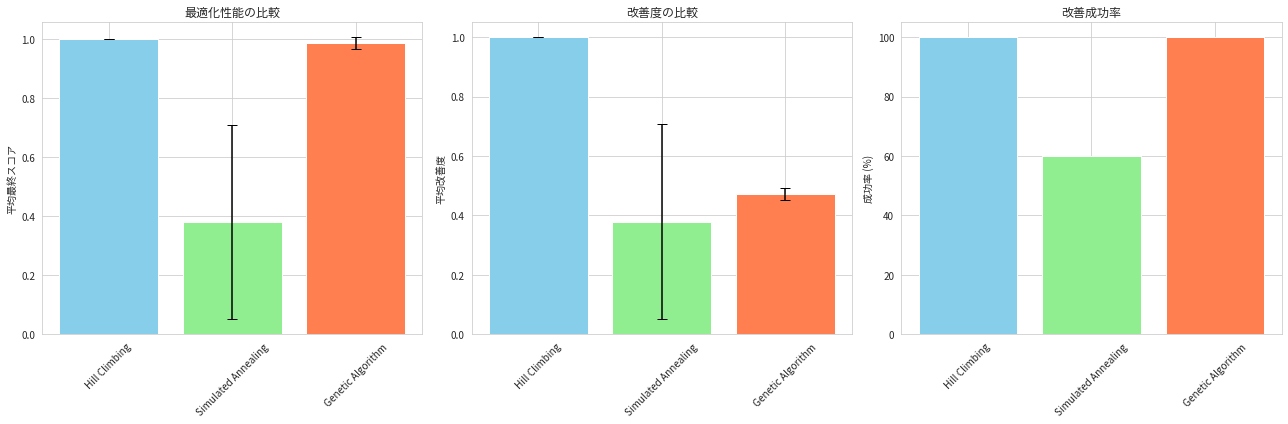

In [9]:
# 各最適化手法の詳細な性能分析
class OptimizationBenchmark:
    """最適化アルゴリズムのベンチマーク"""
    
    def __init__(self, objective_func):
        self.objective_func = objective_func
        self.results = {}
    
    def benchmark_hill_climbing(self, initial_smiles, runs=10):
        """ヒルクライミング法のベンチマーク"""
        results = []
        
        for run in range(runs):
            hc = HillClimbing(self.objective_func, max_iterations=50)
            history = hc.optimize(initial_smiles)
            
            final_score = history[-1]['score'] if history else 0
            iterations = len(history)
            improvement = final_score - history[0]['score'] if len(history) > 1 else 0
            
            results.append({
                'final_score': final_score,
                'iterations': iterations,
                'improvement': improvement,
                'converged': iterations < 50  # 最大反復前に収束したか
            })
        
        return results
    
    def benchmark_simulated_annealing(self, initial_smiles, runs=10):
        """シミュレーテッドアニーリングのベンチマーク"""
        results = []
        
        for run in range(runs):
            sa = SimulatedAnnealing(self.objective_func, initial_temp=20.0, 
                                  final_temp=0.1, max_iterations=100)
            history, best_smiles, best_score = sa.optimize(initial_smiles)
            
            initial_score = self.objective_func.evaluate_molecule(initial_smiles)
            improvement = best_score - initial_score
            
            results.append({
                'final_score': best_score,
                'iterations': len(history['iterations']),
                'improvement': improvement,
                'final_molecule': best_smiles
            })
        
        return results
    
    def benchmark_genetic_algorithm(self, initial_molecules, runs=5):
        """遺伝的アルゴリズムのベンチマーク"""
        results = []
        
        for run in range(runs):
            ga = GeneticAlgorithm(self.objective_func, population_size=10, generations=20)
            history, final_pop = ga.optimize(initial_molecules)
            
            best_individual = max(final_pop, key=lambda x: x['score'])
            initial_best = max([self.objective_func.evaluate_molecule(smiles) 
                              for smiles in initial_molecules])
            
            improvement = best_individual['score'] - initial_best
            
            results.append({
                'final_score': best_individual['score'],
                'generations': len(history['generations']),
                'improvement': improvement,
                'final_molecule': best_individual['smiles'],
                'population_diversity': np.std([ind['score'] for ind in final_pop])
            })
        
        return results
    
    def run_benchmark(self, initial_smiles="CCO", initial_molecules=None):
        """全てのアルゴリズムでベンチマークを実行"""
        if initial_molecules is None:
            initial_molecules = ["CCO", "CC(=O)O", "CCN", "CCC"]
        
        print("最適化アルゴリズムのベンチマーク実行中...")
        
        self.results['hill_climbing'] = self.benchmark_hill_climbing(initial_smiles)
        self.results['simulated_annealing'] = self.benchmark_simulated_annealing(initial_smiles)
        self.results['genetic_algorithm'] = self.benchmark_genetic_algorithm(initial_molecules)
        
        return self.results
    
    def analyze_results(self):
        """ベンチマーク結果の分析"""
        analysis = {}
        
        for method, results in self.results.items():
            scores = [r['final_score'] for r in results]
            improvements = [r['improvement'] for r in results]
            
            analysis[method] = {
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
                'mean_improvement': np.mean(improvements),
                'std_improvement': np.std(improvements),
                'success_rate': sum(1 for imp in improvements if imp > 0) / len(improvements),
                'best_score': max(scores),
                'worst_score': min(scores)
            }
        
        return analysis

# ベンチマークの実行
benchmark = OptimizationBenchmark(objective)
benchmark_results = benchmark.run_benchmark()
analysis = benchmark.analyze_results()

print("最適化アルゴリズムのベンチマーク結果:")
print("=" * 60)

for method, stats in analysis.items():
    print(f"\n{method.replace('_', ' ').title()}:")
    print(f"  平均最終スコア: {stats['mean_score']:.3f} ± {stats['std_score']:.3f}")
    print(f"  平均改善度: {stats['mean_improvement']:.3f} ± {stats['std_improvement']:.3f}")
    print(f"  成功率: {stats['success_rate']:.1%}")
    print(f"  最高スコア: {stats['best_score']:.3f}")
    print(f"  最低スコア: {stats['worst_score']:.3f}")

# ベンチマーク結果の可視化
plt.rcParams['font.family'] = "Noto Sans CJK JP"
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

methods = list(analysis.keys())
method_names = [m.replace('_', ' ').title() for m in methods]

# 1. 平均スコアの比較
mean_scores = [analysis[m]['mean_score'] for m in methods]
std_scores = [analysis[m]['std_score'] for m in methods]

axes[0].bar(method_names, mean_scores, yerr=std_scores, capsize=5, 
           color=['skyblue', 'lightgreen', 'coral'])
axes[0].set_ylabel('平均最終スコア')
axes[0].set_title('最適化性能の比較')
axes[0].tick_params(axis='x', rotation=45)

# 2. 改善度の比較
improvements = [analysis[m]['mean_improvement'] for m in methods]
improvement_stds = [analysis[m]['std_improvement'] for m in methods]

axes[1].bar(method_names, improvements, yerr=improvement_stds, capsize=5,
           color=['skyblue', 'lightgreen', 'coral'])
axes[1].set_ylabel('平均改善度')
axes[1].set_title('改善度の比較')
axes[1].tick_params(axis='x', rotation=45)

# 3. 成功率の比較
success_rates = [analysis[m]['success_rate'] * 100 for m in methods]

axes[2].bar(method_names, success_rates, color=['skyblue', 'lightgreen', 'coral'])
axes[2].set_ylabel('成功率 (%)')
axes[2].set_title('改善成功率')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## まとめ

本ノートブックでは、創薬研究における分子最適化の様々な手法について学習しました：

### 主要なポイント

1. **ヒルクライミング法**:
   - 最も基本的な局所探索手法
   - 単純で高速だが局所最適解に陥りやすい
   - 良い初期解がある場合に有効

2. **遺伝的アルゴリズム（GA）**:
   - 生物進化を模倣した集団ベースの手法
   - 多様な解を維持し、大域的探索が可能
   - 集団サイズと世代数の調整が重要

3. **シミュレーテッドアニーリング（SA）**:
   - 物理的焼きなまし過程を模倣
   - 温度制御により局所最適解からの脱出が可能
   - 温度スケジュールの設計が性能を左右

4. **多目的最適化**:
   - 複数の相反する目標を同時最適化
   - パレート最適解の概念
   - 創薬における現実的な問題設定

5. **目的関数の設計**:
   - 分子性質の定量的評価
   - 薬物らしさ、合成容易性、多様性
   - ドメイン知識の重要性

### 各手法の特徴比較

| 手法 | 探索能力 | 計算コスト | 実装難易度 | 適用場面 |
|------|----------|------------|------------|----------|
| ヒルクライミング | 局所的 | 低 | 易 | 初期解が良好 |
| 遺伝的アルゴリズム | 大域的 | 高 | 中 | 多様性重視 |
| シミュレーテッドアニーリング | 大域的 | 中 | 中 | バランス型 |

### 創薬への応用

- **リード最適化**: 既知活性化合物の改良
- **構造活性相関（SAR）**: 分子修飾による活性変化の理解
- **多目的薬物設計**: 活性・選択性・ADMET・毒性の同時最適化
- **化学空間探索**: 新規骨格の発見
- **分子ライブラリ設計**: 合成優先度の決定

### 次のステップ

1. 機械学習モデルとの組み合わせ
2. 3D構造を考慮した最適化
3. 反応経路を考慮した合成容易性評価
4. 実験データとの統合による目的関数の改良
5. 大規模並列計算による高速化

In [10]:
# 最終統計と学習サマリー
print("分子最適化手法学習の総括:")
print("=" * 50)

# 全体統計
total_optimizations = sum(len(results) for results in benchmark_results.values())
print(f"実行した最適化実験数: {total_optimizations}")

# 最良結果の抽出
best_overall = 0
best_method = ""
best_molecule = ""

for method, results in benchmark_results.items():
    method_best = max(r['final_score'] for r in results)
    if method_best > best_overall:
        best_overall = method_best
        best_method = method
        best_result = max(results, key=lambda x: x['final_score'])
        if 'final_molecule' in best_result:
            best_molecule = best_result['final_molecule']

print(f"最高性能手法: {best_method.replace('_', ' ').title()}")
print(f"最高スコア: {best_overall:.3f}")
if best_molecule:
    print(f"最良分子: {best_molecule}")

print("\n手法選択のガイドライン:")
print("-" * 30)
print("• 高速・シンプル → ヒルクライミング法")
print("• 多様性・頑健性 → 遺伝的アルゴリズム") 
print("• バランス・制御性 → シミュレーテッドアニーリング")
print("• 複数目標 → 多目的最適化")

print("\n学習が完了しました！")
print("実際の創薬研究では、これらの手法を組み合わせて")
print("より効果的な分子最適化システムを構築します。")

分子最適化手法学習の総括:
実行した最適化実験数: 25
最高性能手法: Hill Climbing
最高スコア: 1.000

手法選択のガイドライン:
------------------------------
• 高速・シンプル → ヒルクライミング法
• 多様性・頑健性 → 遺伝的アルゴリズム
• バランス・制御性 → シミュレーテッドアニーリング
• 複数目標 → 多目的最適化

学習が完了しました！
実際の創薬研究では、これらの手法を組み合わせて
より効果的な分子最適化システムを構築します。


## 補助資料

### ダウンロード

- <a class="link" href="/files/optimization_methods_executed.ipynb" download>実行済みJupyter Notebook (.ipynb)</a>